# Task 1

In [ ]:
import numpy as np
import torch
from tqdm import tqdm 
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

In [ ]:
class Linear:
    def __init__(self, in_channels, out_channels):
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.weight = torch.randn(out_channels, in_channels) * np.sqrt(2 / in_channels)
        self.bias = torch.zeros(out_channels)
        
        self.last_input = None
        self.grad_weight = None
        self.grad_bias = None
        
    def forward(self, x, remember=False):
        if remember:
            self.last_input = x
        new_x = torch.matmul(x, self.weight.t()) + self.bias
        return new_x
    
    def backward(self, gradient):
        self.grad_weight = torch.matmul(gradient.t(), self.last_input)
        self.grad_bias = torch.sum(gradient, dim=0)
        new_grad = torch.matmul(gradient, self.weight)
        return new_grad
    
    def update(self, learning_rate):
        self.weight -= learning_rate * self.grad_weight
        self.bias -= learning_rate * self.grad_bias

In [ ]:
class ReLU:
    def __init__(self):
        self.last_input = None
    
    def forward(self, x, remember=False):
        if remember:
            self.last_input = x
        
        new_x = torch.maximum(x, torch.tensor(0.0))
        
        return new_x
    
    def backward(self, gradient):
        return (self.last_input > 0).float() * gradient
    
    def update(self, learning_rate):
        # We don't have any parameters here
        pass

In [44]:
############################################# no need to change anything below this line #############################################    
class Softmax:
    def __init__(self, dim=-1):
        self.last_output = None
        self.dim = dim
        
    def forward(self, x, remember=False):
        x = torch.exp(x-torch.amax(x, dim=-1, keepdim=True)) #numerical stable version -> normalize by max(x)
        x = x/(torch.sum(x, dim=self.dim, keepdim=True)+1e-12)
        if remember:
            self.last_output = x
        return x
    
    def backward(self, gradient):
        jacobian = -self.last_output[:,:,None]*self.last_output[:,None,:] #BxLxL
        #correct diagonal entries
        jacobian += torch.eye(self.last_output.size(-1)).unsqueeze(0)*self.last_output.unsqueeze(-1).repeat(1,1,self.last_output.size(-1))
        return torch.einsum("bj,bji->bi", gradient, jacobian)
    
    def update(self, learning_rate):
        #we don't have any parameters here
        pass


class CrossEntropyLoss:
    def __init__(self, dim=-1):
        self.last_input = None
        self.last_ground_truth = None
        self.dim = dim
    
    def forward(self, p, y):
        #convert y to one hot
        one_hot = torch.eye(p.size(-1))[y]
        self.last_input = p
        self.last_ground_truth = one_hot
        
        losses = -torch.sum(one_hot*torch.log(p), dim=-1)
        
        total_loss = torch.mean(losses)
        
        return total_loss
    
    def backward(self):
        return torch.where(self.last_ground_truth==1,-1.0/self.last_input, 0.0)
          
              
class MLP:
    def __init__(self, in_channels=2, hidden_channels=[], out_channels=2):
        self.in_channels = in_channels
        
        self.layers = []
        if len(hidden_channels)==0:
            self.layers.append(Linear(in_channels, out_channels))
        else:
            self.layers.append(Linear(in_channels, hidden_channels[0]))
            self.layers.append(ReLU())
            for i in range(len(hidden_channels)-1):
                self.layers.append(Linear(hidden_channels[i], hidden_channels[i+1]))
                self.layers.append(ReLU())
            self.layers.append(Linear(hidden_channels[-1], out_channels))
        self.layers.append(Softmax(dim=-1))
        
        self.criterion = CrossEntropyLoss(dim=-1)
        
    def forward(self, x, remember=False):
        for layer in self.layers:
            x = layer.forward(x, remember=remember)
        return x
    
    def backward(self): #calculate gradients
        grad = self.criterion.backward()
        
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        
    def update(self, learning_rate): #update each layer via gradient descent
        for layer in self.layers:
            layer.update(learning_rate)
    
    def training_step(self, x, y, learning_rate):
        probabilities = self.forward(x, remember=True) #store inputs for backward pass!
        loss = self.criterion.forward(probabilities, y)
        self.backward() #calculate gradients
        self.update(learning_rate) #update using gradient descent
        
        return loss
            
############################################# no need to change anything above this line #############################################  

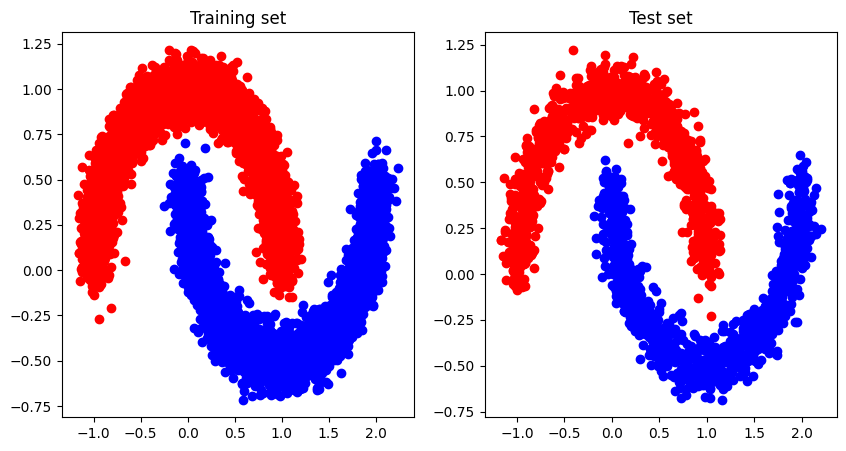

In [45]:
Ntrain = 8000
Ntest = 2000
Xtrain, ytrain = make_moons(n_samples=Ntrain, noise=0.08, random_state=42)
Xtest, ytest = make_moons(n_samples=Ntest, noise=0.08, random_state=42)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(Xtrain[ytrain==0,0], Xtrain[ytrain==0,1], c='r')
plt.scatter(Xtrain[ytrain==1,0], Xtrain[ytrain==1,1], c='b')
plt.title('Training set')

plt.subplot(1,2,2)
plt.scatter(Xtest[ytest==0,0], Xtest[ytest==0,1], c='r')
plt.scatter(Xtest[ytest==1,0], Xtest[ytest==1,1], c='b')
plt.title('Test set')
plt.show()

100%|██████████| 250/250 [00:00<00:00, 2523.64it/s]


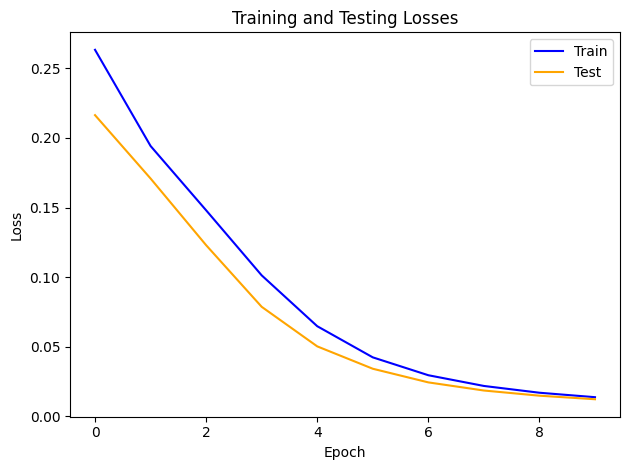

In [46]:

#rescale data to [-1,1]
amin = np.amin(Xtrain, axis=0, keepdims=True)
amax = np.amax(Xtrain, axis=0, keepdims=True)

Xtrain = ((Xtrain-amin)/(amax-amin)-0.5)/0.5
Xtest = ((Xtest-amin)/(amax-amin)-0.5)/0.5


batch_size = 32
num_batches_train = int(np.ceil(Ntrain/batch_size))
num_batches_test = int(np.ceil(Ntest/batch_size))

num_epochs = 10

mlp = MLP(2, [30,30], 2)
learning_rate = 1e-3


#train network
losses_train_epoch = []
losses_test_epoch = []

for epoch in range(num_epochs):
    losses_train = []
    losses_test = []

    # reshuffle training data
    ind = np.random.permutation(len(Xtrain))
    Xtrain = Xtrain[ind]
    ytrain = ytrain[ind]
    
    for it in tqdm(range(num_batches_train)):
        start = it * batch_size
        end = min((it + 1) * batch_size, len(Xtrain))
        X = torch.FloatTensor(Xtrain[start:end])
        y = torch.LongTensor(ytrain[start:end])

        loss = mlp.training_step(X, y, learning_rate)
        losses_train.append(loss.item())

    for it in range(num_batches_test):
        start = it * batch_size
        end = min((it + 1) * batch_size, len(Xtest))
        X = torch.FloatTensor(Xtest[start:end])
        y = torch.LongTensor(ytest[start:end])

        probabilities = mlp.forward(X)
        loss = mlp.criterion.forward(probabilities, y)
        losses_test.append(loss.item())

    losses_train_epoch.append(np.mean(losses_train))
    losses_test_epoch.append(np.mean(losses_test))

plt.plot(losses_train_epoch, label="Train", color="blue")
plt.plot(losses_test_epoch, label="Test", color="orange")

plt.title('Training and Testing Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



100%|██████████| 250/250 [00:00<00:00, 296.21it/s]


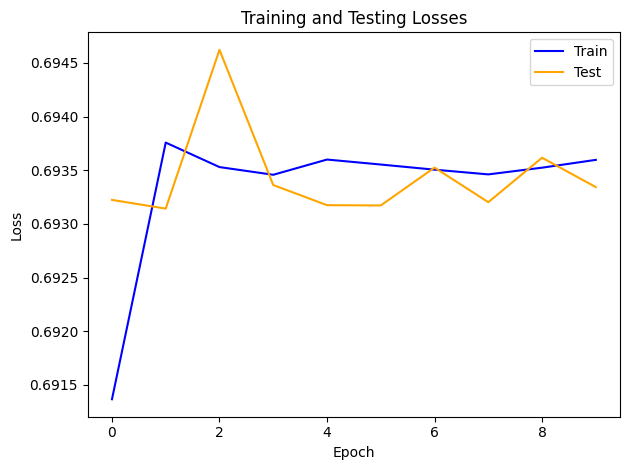

In [56]:

#rescale data to [-1,1]
amin = np.amin(Xtrain, axis=0, keepdims=True)
amax = np.amax(Xtrain, axis=0, keepdims=True)

Xtrain = ((Xtrain-amin)/(amax-amin)-0.5)/0.5
Xtest = ((Xtest-amin)/(amax-amin)-0.5)/0.5


batch_size = 32
num_batches_train = int(np.ceil(Ntrain/batch_size))
num_batches_test = int(np.ceil(Ntest/batch_size))

num_epochs = 10

mlp = MLP(2, [30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30], 2)
learning_rate = 2e-3


#train network
losses_train_epoch = []
losses_test_epoch = []

for epoch in range(num_epochs):
    losses_train = []
    losses_test = []

    # reshuffle training data
    ind = np.random.permutation(len(Xtrain))
    Xtrain = Xtrain[ind]
    ytrain = ytrain[ind]
    
    for it in tqdm(range(num_batches_train)):
        start = it * batch_size
        end = min((it + 1) * batch_size, len(Xtrain))
        X = torch.FloatTensor(Xtrain[start:end])
        y = torch.LongTensor(ytrain[start:end])

        loss = mlp.training_step(X, y, learning_rate)
        losses_train.append(loss.item())

    for it in range(num_batches_test):
        start = it * batch_size
        end = min((it + 1) * batch_size, len(Xtest))
        X = torch.FloatTensor(Xtest[start:end])
        y = torch.LongTensor(ytest[start:end])

        probabilities = mlp.forward(X)
        loss = mlp.criterion.forward(probabilities, y)
        losses_test.append(loss.item())

    losses_train_epoch.append(np.mean(losses_train))
    losses_test_epoch.append(np.mean(losses_test))

plt.plot(losses_train_epoch, label="Train", color="blue")
plt.plot(losses_test_epoch, label="Test", color="orange")

plt.title('Training and Testing Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



* Exploding gradients, some nan values due to the gradiens going to minus or plus infinity as we stack up the layers. Model is not learning something after the second epoch.

* Also in some runs, one may observe nan values for the losses

* When we make the initialization with torch.random without the np.sqrt(2 / in_channels) normalization, the graidents explode much quicker.

* Also possible other problem, normalization is the remedy. This is a mock dataset, and it is perfectly separable with almost the same discrimator function, hence it may not overfits, but if we increase the noise in test set, and get a higher number of test samples it will tend to overfit.



# Task 2

In [1]:
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import numpy as np
from tqdm.auto import tqdm  # Not needed but very cool!
import matplotlib.pyplot as plt


c:\Users\kutay\miniconda3\envs\deepl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'Number of images': 60000, 'Minimum pixel value': 0, 'Maximum pixel value': 255, 'Mean pixel value': 33.318421449829934, 'Shape of the dataset': (60000, 28, 28), 'Data type of the dataset': dtype('uint8')}


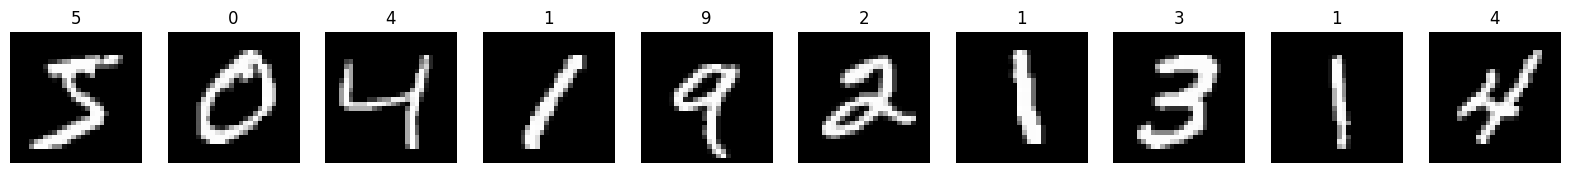

In [2]:
def load_data(train=True):
    mnist = datasets.MNIST('../data',
                           train=train,
                           download=True)
    return mnist

def plot_examples(data, num_examples=10):
    fig, axes = plt.subplots(1, num_examples, figsize=(20, 2))
    for i, (image, label) in enumerate(data):
        image = np.array(image)
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(label)
        if i == num_examples - 1:
            break
def descriptives(data):
    images, labels = zip(*data)
    num_images = len(images)
    images = [np.array(image) for image in images]
    images = np.array(images)
    
    min_pixel_value = images.min()
    max_pixel_value = images.max()
    mean_pixel_value = images.mean()
    shape_of_dataset = images.shape
    dtype_of_dataset = images.dtype
    
    statistics = {
        "Number of images": num_images,
        "Minimum pixel value": min_pixel_value,
        "Maximum pixel value": max_pixel_value,
        "Mean pixel value": mean_pixel_value,
        "Shape of the dataset": shape_of_dataset,
        "Data type of the dataset": dtype_of_dataset
    }
    
    return statistics


data = load_data()
plot_examples(data)
desciptive_stats = descriptives(data)
print(desciptive_stats)

In [3]:
def convert_mnist_to_vectors(data, desciptive_stats):
    '''Converts the ``[28, 28]`` MNIST images to vectors of size ``[28*28]``.
       It outputs mnist_vectors as a array with the shape of [N, 784], where
       N is the number of images in data.
    '''
    min_pixel_value = desciptive_stats["Minimum pixel value"]
    max_pixel_value = desciptive_stats["Maximum pixel value"]
    mnist_vectors = []
    labels = []

    for image, label in tqdm(data):
        image = np.array(image, dtype=np.float32)
        image = ((image-min_pixel_value)/(max_pixel_value-min_pixel_value)-0.5)/0.5
        mnist_vectors.append(image.flatten())
        labels.append(label)
        
    return np.array(mnist_vectors), np.array(labels)


mnist_vectors, labels =  convert_mnist_to_vectors(data=data, desciptive_stats=desciptive_stats)

100%|██████████| 60000/60000 [00:01<00:00, 36041.35it/s]


100%|██████████| 60000/60000 [00:01<00:00, 34753.53it/s]


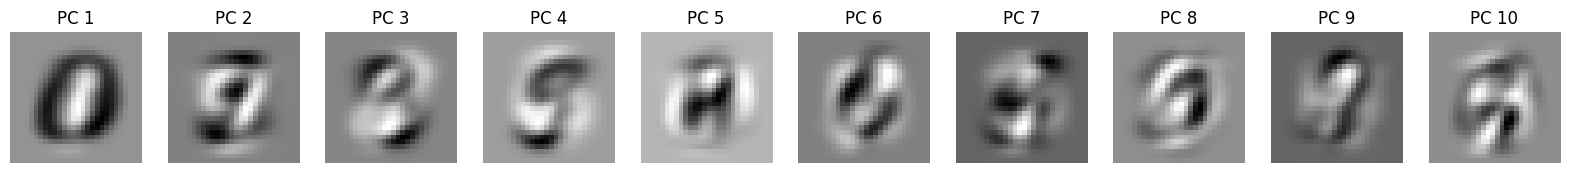

In [4]:
def do_pca(data, desciptive_stats):
    '''Returns matrix [784x784] whose columns are the sorted eigenvectors.
       Eigenvectors (prinicipal components) are sorted according to their
       eigenvalues in decreasing order.
    '''

    mnist_vectors, labels = convert_mnist_to_vectors(data, desciptive_stats=desciptive_stats)
    #     prepare_data(mnist_vectors)

    # compute covariance matrix of data with shape [784x784]
    cov = np.cov(mnist_vectors.T)

    # compute eigenvalues and vectors
    eigVals, eigVec = np.linalg.eig(cov)

    # sort eigenVectors by eigenValues
    sorted_index = eigVals.argsort()[::-1]
    eigVals = eigVals[sorted_index]
    sorted_eigenVectors = eigVec[:, sorted_index]
    return sorted_eigenVectors.astype(np.float32).T

def plot_pcs(sorted_eigenVectors, num=10):
    fig, axes = plt.subplots(1, num, figsize=(20, 2))
    for i in range(num):
        axes[i].imshow(sorted_eigenVectors[i].reshape(28, 28), cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"PC {i+1}")

eigen_vectors = do_pca(data, desciptive_stats=desciptive_stats)
plot_pcs(eigen_vectors)


I am seeing the principle components, which are the most important features of the dataset. I am seeing the curvatures, and some subtle features such as thickness and shapes which are important for classification. If the problem was easy, and the dataset was not noisy, also easily separable I would expect to see the handwritten digits in a compact distinguishable form, however the mnist dataset is not that easy, hence I see some curvature, thickness difference and round shapes where the most variation is, but most of them are not distinguishable. Furthermore, if it is meant to have less number of classes as dataset being easy, in that sense, and also in the first sense, we would need less principle components to explain the variation in the dataset.

100%|██████████| 60000/60000 [00:01<00:00, 36040.24it/s]


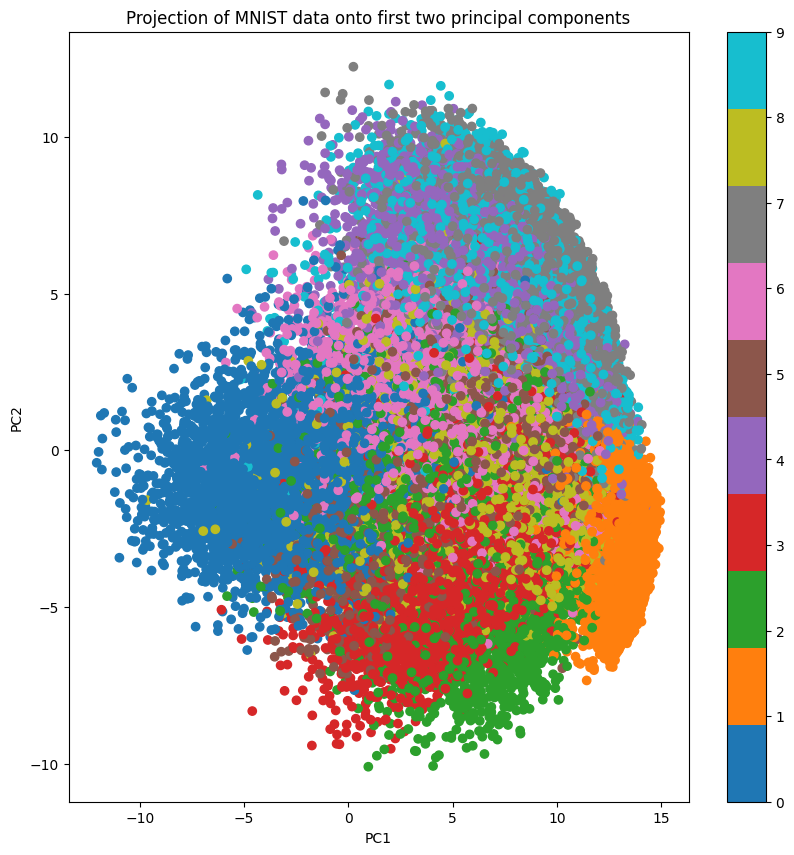

In [5]:
def plot_projection(sorted_eigenVectors, data, desciptive_stats):
    '''Projects ``data`` onto the first two ``sorted_eigenVectors`` and makes
    a scatterplot of the resulting points'''
    mnist_vectors, labels = convert_mnist_to_vectors(data, desciptive_stats=desciptive_stats)
    first_two_eigenVectors = sorted_eigenVectors[:2]
    projection = np.dot(mnist_vectors, first_two_eigenVectors.T)
    plt.figure(figsize=(10, 10))
    plt.scatter(projection[:, 0], projection[:, 1], c=labels, cmap='tab10')
    plt.colorbar()
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Projection of MNIST data onto first two principal components')
    plt.show()



plot_projection(eigen_vectors, data, desciptive_stats)


It is a plot over the 2 most important features of the MNIST. We can observe that the dataset is complicated, and obviously features are not linearly or easily separable after the feature extraction with pca on 2 dimensions. But as we can see from the above graph, the 0 is pretty distinguishable compared to the other ones. The other values are inside of each other.


100%|██████████| 60000/60000 [00:01<00:00, 32750.73it/s]


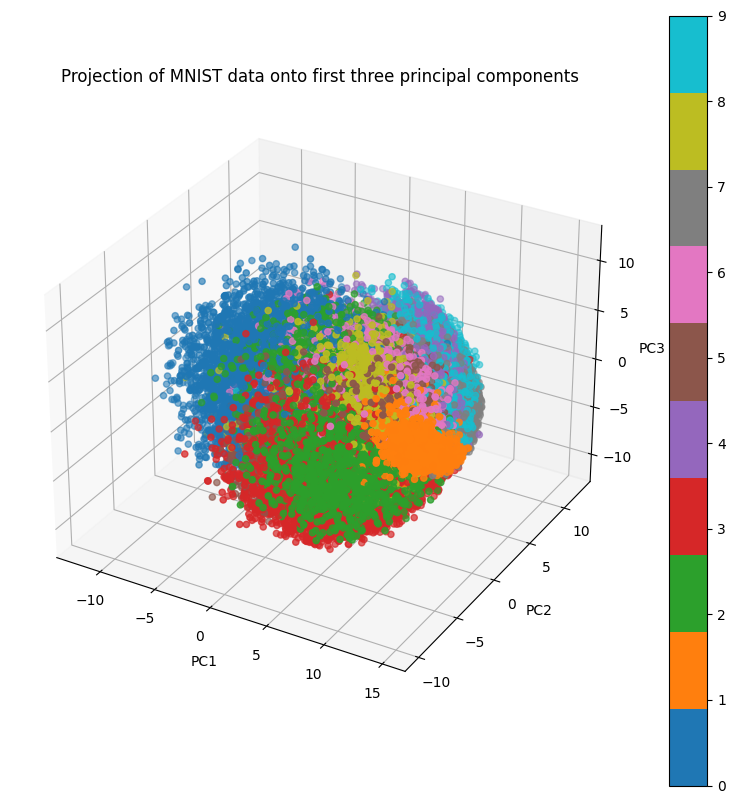

In [6]:
from mpl_toolkits.mplot3d import Axes3D
"""
    This is just for the fantasy. I wanted to see how the 3d components look like.
"""
def plot_projection_3d(sorted_eigenVectors, data, descriptive_stats):
    '''Projects ``data`` onto the first three ``sorted_eigenVectors`` and makes
    a scatterplot of the resulting points'''
    mnist_vectors, labels = convert_mnist_to_vectors(data, descriptive_stats)
    first_three_eigenVectors = sorted_eigenVectors[:3]
    projection = np.dot(mnist_vectors, first_three_eigenVectors.T)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(projection[:, 0], projection[:, 1], projection[:, 2], c=labels, cmap='tab10')
    plt.colorbar(scatter)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title('Projection of MNIST data onto first three principal components')
    plt.show()

plot_projection_3d(eigen_vectors, data, desciptive_stats)

# Task 3


Epoch:   0%|          | 0/5 [00:08<?, ?it/s]

Batch Accuracy: 87.5%, Loss: 0.24534843862056732


Test: 100%|██████████| 625/625 [00:00<00:00, 1082.01it/s]


Validation Accuracy: 90.96%


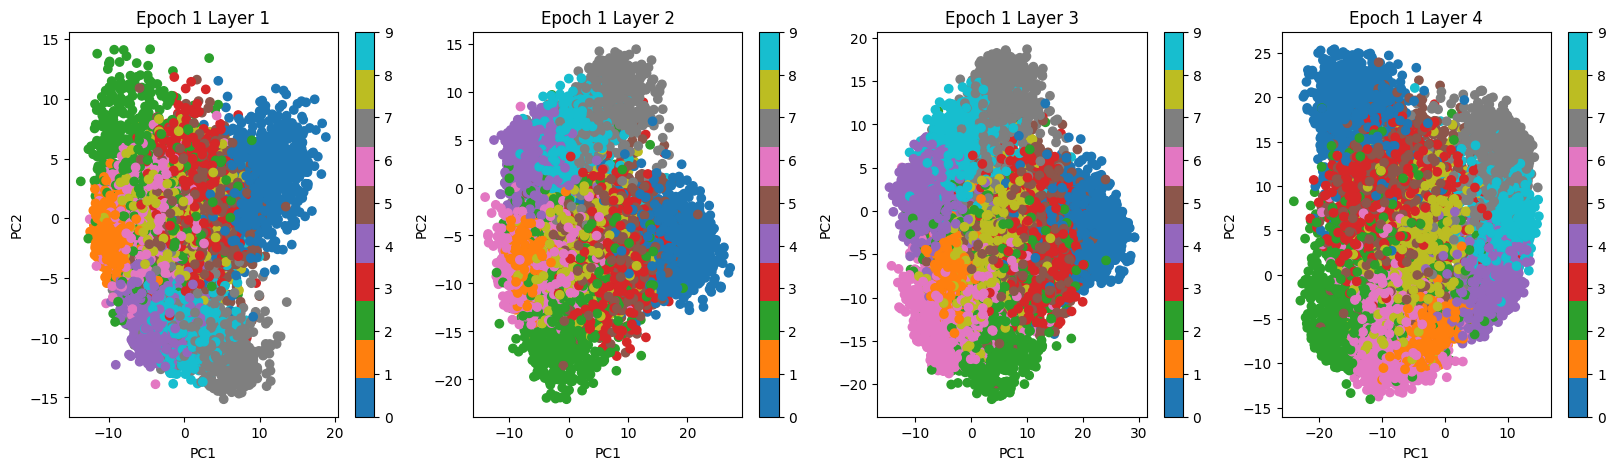

Epoch:  20%|██        | 1/5 [00:18<00:40, 10.12s/it]

Batch Accuracy: 81.25%, Loss: 0.30724817514419556


Test: 100%|██████████| 625/625 [00:00<00:00, 1178.62it/s]


Validation Accuracy: 93.16%


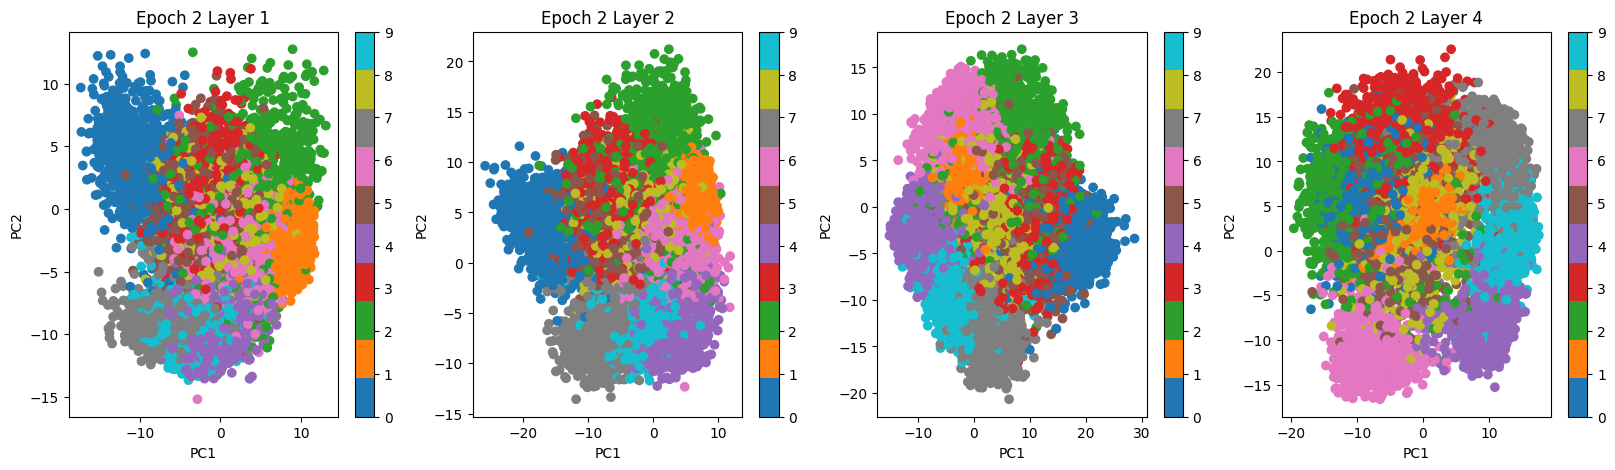

Epoch:  40%|████      | 2/5 [00:54<00:30, 10.33s/it]

Batch Accuracy: 100.0%, Loss: 0.09231188893318176


Test: 100%|██████████| 625/625 [00:04<00:00, 143.93it/s]


Validation Accuracy: 94.81%


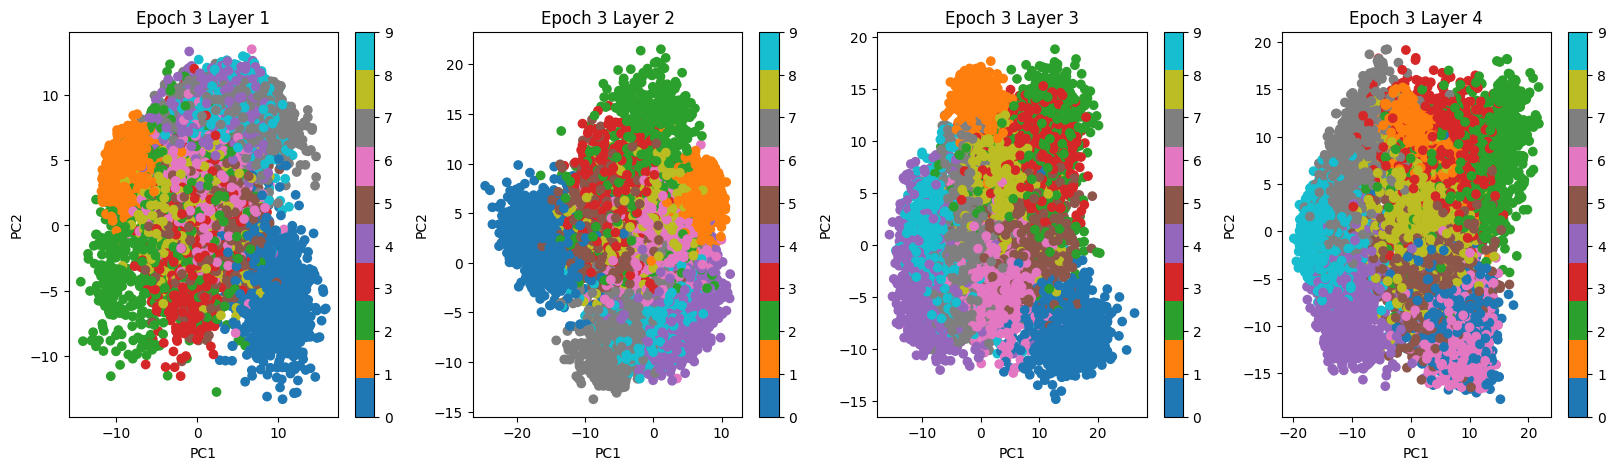

Epoch:  60%|██████    | 3/5 [01:25<00:52, 26.22s/it]

Batch Accuracy: 93.75%, Loss: 0.18951697647571564


Test: 100%|██████████| 625/625 [00:03<00:00, 164.82it/s]


Validation Accuracy: 94.81%


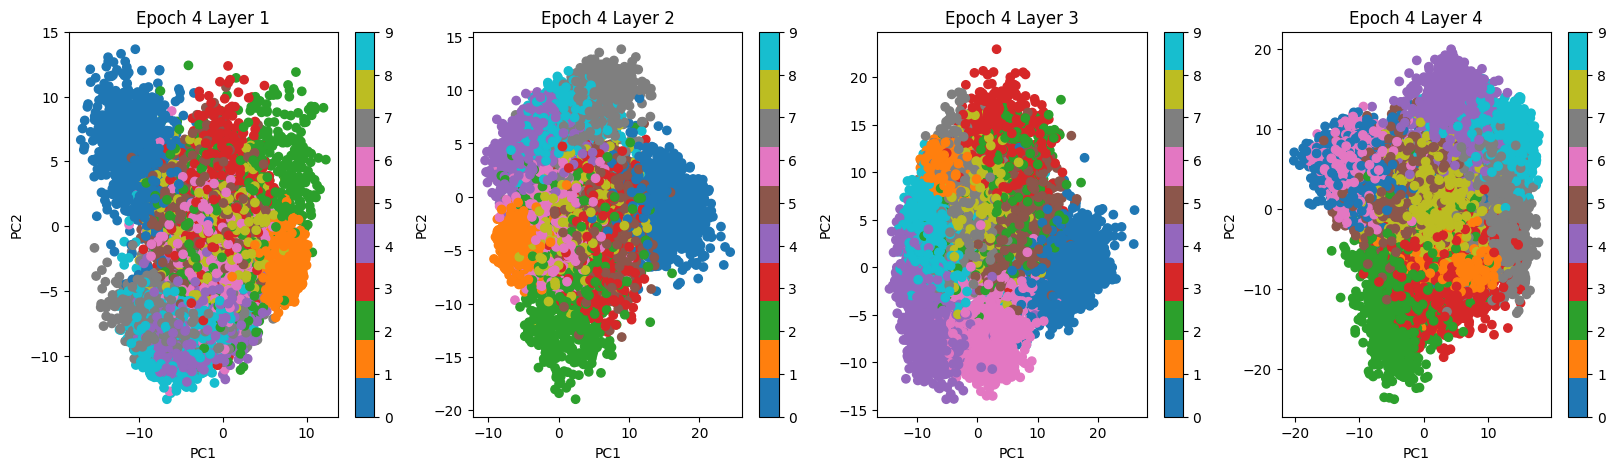

Epoch:  80%|████████  | 4/5 [02:03<00:28, 28.25s/it]

Batch Accuracy: 93.75%, Loss: 0.26193857192993164


Test: 100%|██████████| 625/625 [00:00<00:00, 1174.39it/s]


Validation Accuracy: 95.33%


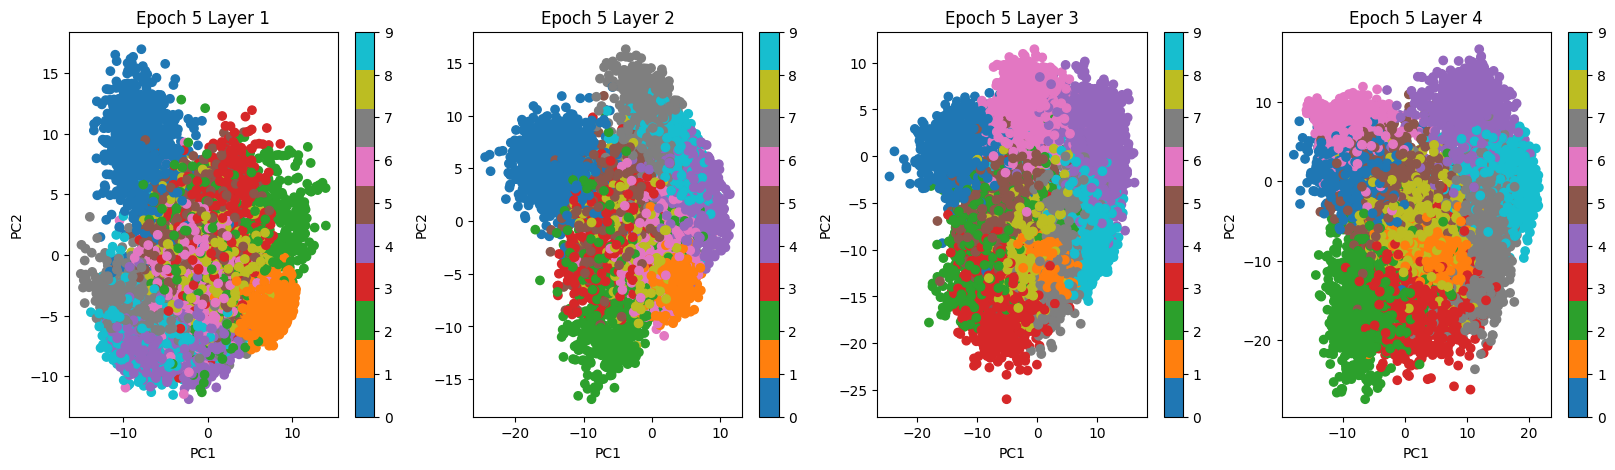

Epoch: 100%|██████████| 5/5 [02:05<00:00, 25.00s/it]


In [34]:
from torchvision import datasets
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

class MultilayerPerceptron(nn.Module):
    
    def __init__(self, size_hidden=100, size_out=10):
        super().__init__()
        
        self.fc1 = nn.Linear(784, size_hidden)
        self.fc2 = nn.Linear(size_hidden, size_hidden)
        self.fc3 = nn.Linear(size_hidden, size_hidden)
        self.fc4 = nn.Linear(size_hidden, size_hidden)
        self.out_layer = nn.Linear(size_hidden, size_out)
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        activations = []
        out = self.fc1(x)
        out = self.relu(out)
        activations.append(out)

        out = self.fc2(out)
        out = self.relu(out)
        activations.append(out)

        out = self.fc3(out)
        out = self.relu(out)
        activations.append(out)

        out = self.fc4(out)
        out = self.relu(out)
        activations.append(out)

        out = self.out_layer(out)

        return out, activations

class MnistVectors(torch.utils.data.Dataset):
    '''A Pytorch Dataset, which does the same data preparation as was done in
    the PCA exercise.'''

    def __init__(self, split='train'):
        super().__init__()
        
        mnist = datasets.MNIST('../data',
                               train=split=='train',
                               download=True)

        self.mnist_vectors, self.labels = convert_mnist_to_vectors(mnist, desciptive_stats)

            
    def __getitem__(self, idx):
        '''Implements the ``[idx]`` method. Here we convert the numpy data to
        torch tensors.
        '''

        mvec = torch.tensor(self.mnist_vectors[idx]).float()
        label = torch.tensor(self.labels[idx]).long()

        return mvec, label
    
    def __len__(self):
        return len(self.labels)


def batch_accuracy(prediction, label):
    return (torch.sum(prediction == label).item() / len(label)) * 100

def class_label(prediction):
    return torch.argmax(prediction, dim=1)

def train(use_gpu=False):

    P = MultilayerPerceptron()
    
    TrainData = MnistVectors()
    TestData = MnistVectors('test')

    Dl = DataLoader(TrainData, batch_size=16, shuffle=True)
    testDl = DataLoader(TestData, batch_size=16, shuffle=False)
    
    optimizer =  torch.optim.Adam(P.parameters(), lr=1e-4)

    criterion =  nn.CrossEntropyLoss()
    
    if use_gpu:
        P.cuda()
        criterion.cuda()
    
    for epoch in tqdm(range(5), desc='Epoch'):
        val_activations = []
        val_labels = []
        for step, [example, label] in enumerate(tqdm(Dl, desc='Batch')):
            if use_gpu:
                example = example.cuda()
                label = label.cuda()
     
            optimizer.zero_grad()
            
            prediction, activations = P(example)
            
            loss = criterion(prediction, label)
            loss.backward()
            optimizer.step()

            
        acc = batch_accuracy(class_label(prediction), label)
        tqdm.write('Batch Accuracy: {}%, Loss: {}'.format(acc, loss))
        
        accuracies = []
        for idx, [test_ex, test_l] in enumerate(tqdm(testDl, desc='Test')):
            if use_gpu:
                test_ex = test_ex.cuda()
                test_l = test_l.cuda()

                with torch.no_grad():
                    predictions, activations = P(test_ex)
                    val_activations.append(activations)
                    val_labels.append(test_l.cpu().numpy())

                acc = batch_accuracy(class_label(predictions), test_l)
                accuracies.append(acc)
        print('Validation Accuracy: {}%'.format(np.mean(accuracies)))
        
        torch.save(P.state_dict(), 'perceptron_{}.ckpt'.format(step))
        
        concatenated_activations = [torch.cat([val_activations[i][j] for i in range(len(val_activations))], dim=0) for j in range(4)]
        numpy_activations = [tensor.cpu().numpy() for tensor in concatenated_activations]
        numpy_labels = np.concatenate(val_labels)

        plt.figure(figsize=(20, 5))  
        for i, acts in enumerate(numpy_activations):
            cov = np.cov(acts.T)
            eigVals, eigVec = np.linalg.eig(cov)
            sorted_index = eigVals.argsort()[::-1]
            eigVals = eigVals[sorted_index]
            sorted_eigenVectors = eigVec[:, sorted_index]
            sorted_eigenVectors = sorted_eigenVectors.astype(np.float32).T

            first_two_eigenVectors = sorted_eigenVectors[:2]
            projection = np.dot(acts, first_two_eigenVectors.T)

            plt.subplot(1, 4, i+1)  
            plt.scatter(projection[:, 0], projection[:, 1], c=numpy_labels, cmap='tab10')
            plt.colorbar()
            plt.xlabel('PC1')
            plt.ylabel('PC2')
            plt.title("Epoch {} Layer {}".format(epoch + 1, (i+1)))

        plt.show()
            
        


activations = train(use_gpu=True if torch.cuda.is_available() else False)


After performing dimensionality reduction using PCA on the activation outputs of the four layers of a multi-layer perceptron trained on the MNIST dataset for five epochs, I observed that the majority of intra-class variation could be explained by just two principal components. This indicates that the network learned to effectively capture the essential characteristics of the data in a lower-dimensional space.

As the visualization continues,  it became apparent that the classes formed distinct clusters, suggesting that the network successfully learned to differentiate between the digit classes, which we can see from our accuracy and loss values. However there are still some very minor overlaps, and it did not clustered the data 100% distinguishable.

For the comparison, they are different. Task 2 provides insight into the intrinsic separability of the dataset, while Task 3 evaluates the efficacy of the MLP in learning discriminative features for classification. In task 3, the data become more clusters, which shows that MLP learnt something. 

Also, due to the complexity, MLP is not the perfect choice for this task. The number of the trainable parameters is significantly much more than the convolutional layers. A simple example from the class and slides, GENAI-4, slide26

Convolutionalal Networks
* Parameter reduction:
* Assume input of size 32 x 32 x 3, kernel size 5
* Applying 30 filters leads to output of size 32 x32 x 30
* Fully connected layer:
* Number of neurons: 32 x 32 x 30 = 30720
* Weights per neuron: 5 x 5 x 3 =75
* Total number of weights: ~ 3 million
* Convolutional layer
* 5 x 5 x 3 x 30 = 2250 weights
* Equals fully connected layer with shared parameters

Plus, convolutions automatically detect the most important features plus performs a dimensionality reduction, which is almost the same purpose of pca, although they can aso capture the nonlinear features. Hence it will be a useful tool for capturing images. Furthermore, they have some cult models such as LeNet to be able to capture the digits.